# Predicting Student Test Scores Competition
The following notebook contains my attempt at the Predicting Student Test Scores competitions: https://www.kaggle.com/competitions/playground-series-s6e1/overview. My work finished 1093rd on the leaderboard, placing in the top 23%. My work was unfourtuantely submitted just after the deadline and is therefore not a true representation of competition conditions.

### Data Dictionary

| Variable | Definition | Key |
| :--- | :--- | :--- |
| **id** | Unique student identifier | |
| **age** | Age of the student | Years (e.g., 17 - 24) |
| **gender** | Biological sex | female, male, other |
| **course** | Degree program enrolled | B.Sc, B.Tech, BCA, BA, B.Com, Diploma |
| **study_hours** | Daily self-study time | Continuous (Hours) |
| **class_attendance** | Percentage of classes attended | 0 to 100 (%) |
| **internet_access** | Availability of home internet | no, yes |
| **sleep_hours** | Average nightly sleep | Continuous (Hours) |
| **sleep_quality** | Subjective quality of rest | poor, average, good |
| **study_method** | Primary learning approach | online videos, self-study, coaching, group study, mixed |
| **facility_rating** | Quality of study facilities | low, medium, high |
| **exam_difficulty** | Complexity level of the exam | easy, moderate, hard |
| **exam_score** | **Target:** Result on the exam | 0.0 to 100.0 |

# View Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
train_df = pd.read_csv("train.csv", index_col="id")
test_df = pd.read_csv("test.csv", index_col="id")

# Feature engineering

First we can create a new regression feature using the optimal weights of all features. Optimal weights are found using regression, which can only be done on numeric features. Therefore, we one-hot encode categorical features first.

It is a sensible approach to only produce a new features based on the most impactful data. This has been done by only selecting features that have correlation with exam_score greater than 10%.

In [3]:
train_df.head(2)

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,exam_difficulty,exam_score
id,,,,,,,,,,,,
0,21,female,b.sc,7.91,98.8,no,4.9,average,online videos,low,easy,78.3
1,18,other,diploma,4.95,94.8,yes,4.7,poor,self-study,medium,moderate,46.7


In [4]:
all_columns = set(train_df.columns)
numeric_columns = set(train_df.select_dtypes(include=['number']).columns)
cat_columns = list(all_columns - numeric_columns)

train_encoded = pd.get_dummies(train_df, columns=cat_columns, drop_first = True, dtype=int)
test_encoded = pd.get_dummies(test_df, columns=cat_columns, drop_first = True, dtype=int)

In [5]:
corr_matrix = train_encoded.corr(numeric_only=True)
exam_corr = corr_matrix[['exam_score']].sort_values(by='exam_score', ascending=False)
strong_corr = exam_corr[exam_corr["exam_score"].abs() > 0.1]

display(strong_corr)

,exam_score
exam_score,1.000000
study_hours,0.762267
class_attendance,0.360954
sleep_quality_good,0.203258
sleep_hours,0.167410
study_method_self-study,-0.130269
facility_rating_low,-0.171604
sleep_quality_poor,-0.208717


In [6]:
X = train_encoded[["study_hours",
              "class_attendance", 
              "sleep_quality_good",
              "sleep_hours",
              "study_method_self-study",
              "facility_rating_low",
              "sleep_quality_poor"
             ]]
y = train_df['exam_score'] 

model = LinearRegression()
model.fit(X, y)

print(f"Intercept: {model.intercept_:.4f}")
for feature, coef in zip(X.columns, model.coef_):
    print(f"{feature}: {coef:.4f}")

Intercept: 10.5363
study_hours: 5.7209
class_attendance: 0.3131
sleep_quality_good: 4.1703
sleep_hours: 1.3355
study_method_self-study: -4.2032
facility_rating_low: -5.4919
sleep_quality_poor: -4.7014


In [7]:
intercept = model.intercept_
coef = model.coef_

train_df["reg_feature"] = (
    train_encoded["study_hours"] * coef[0] + 
    train_encoded["sleep_quality_good"] * coef[1] +
    train_encoded["sleep_hours"] * coef[2] +
    train_encoded["study_method_self-study"] * coef[3] +
    train_encoded["facility_rating_low"] * coef[4] +
    train_encoded["sleep_quality_poor"] * coef[5] + 
    intercept
)

test_df["reg_feature"] = (
    test_encoded["study_hours"] * coef[0] + 
    test_encoded["sleep_quality_good"] * coef[1] +
    test_encoded["sleep_hours"] * coef[2] +
    test_encoded["study_method_self-study"] * coef[3] +
    test_encoded["facility_rating_low"] * coef[4] +
    test_encoded["sleep_quality_poor"] * coef[5] + 
    intercept
)

print("="*30)
print("REGRESSION FEATURE ADDED SUCCESSFULLY")
print("="*30)

REGRESSION FEATURE ADDED SUCCESSFULLY


As this new regression feature is derived from many features, we can also create a second regression feature based off of the most impactful data, i.e. features with > 20% correlation to exam_score

In [8]:
X = train_encoded[["study_hours",
              "class_attendance", 
              "sleep_quality_good",
              "sleep_quality_poor"]]
y = train_df['exam_score'] 

model2 = LinearRegression()
model2.fit(X, y)

print(f"Intercept: {model2.intercept_:.4f}")
print("=" * 30)
for feature, coef in zip(X.columns, model2.coef_):
    print(f"{feature}: {coef:.4f}")

Intercept: 16.1973
study_hours: 5.8197
class_attendance: 0.3222
sleep_quality_good: 4.3119
sleep_quality_poor: -4.8237


In [9]:
intercept2 = model.intercept_
coef2 = model.coef_

train_df["reg_feature2"] = (
    train_encoded["study_hours"] * coef2[0] + 
    train_encoded["class_attendance"] * coef2[1] + 
    train_encoded["sleep_quality_good"] * coef2[2] +
    train_encoded["sleep_quality_poor"] * coef2[3] + 
    intercept2
)

test_df["reg_feature2"] = (
    test_encoded["study_hours"] * coef2[0] + 
    test_encoded["class_attendance"] * coef2[1] + 
    test_encoded["sleep_quality_good"] * coef2[2] +
    test_encoded["sleep_quality_poor"] * coef2[3] + 
    intercept2
)

print("="*30)
print("SECOND REGRESSION FEATURE ADDED SUCCESSFULLY")
print("="*30)

SECOND REGRESSION FEATURE ADDED SUCCESSFULLY


As study hours has the greatest impact on exam_score by far, we can break this variable up further, investigating if study hours and exam score have a linear relationship.

In [10]:
train_df["study_hours"].describe()

count    630000.000000
mean          4.002337
std           2.359880
min           0.080000
25%           1.970000
50%           4.000000
75%           6.050000
max           7.910000
Name: study_hours, dtype: float64

Gain in points for each additional hour:


<Axes: xlabel='hour_bin'>

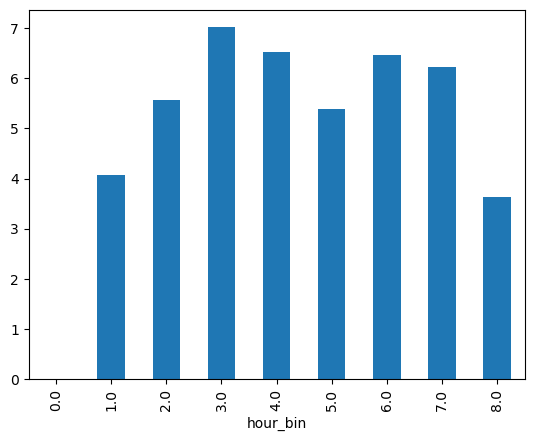

In [11]:
train_df['hour_bin'] = train_df['study_hours'].round()

bin_analysis = train_df.groupby('hour_bin')['exam_score'].mean().diff()

print("Gain in points for each additional hour:")

bin_analysis.plot(kind="bar")

As expected, study_hours and exam_score have a non-linear relationship. Studying an additional hour from 1-2 hours is different to studying and additional 3-4 hours. The graph shows two humps at 3 and 6 hours. We can use a polynomial model (order 3) to capture this two hump relationship. The overall shape is also a U shape, which can be captured by a standard order 2 parabola. Including both order 3 and 2 polynomial variable allows the model to select which features represents the data better.

In [12]:
train_df = train_df.drop("hour_bin", axis=1)

In [13]:
train_df["study_hours_poly_3"] = train_df["study_hours"] ** 3

test_df["study_hours_poly_3"] = test_df["study_hours"] ** 3

print("="*50)
print("feature added: study_hours_poly_3")
print("="*50)

feature added: study_hours_poly_3


In [14]:
num_col_list = list(numeric_columns)

for col in num_col_list:
    if col == "exam_score":
        continue
    train_df[f'{col}_sq'] = train_df[col] ** 2
    test_df[f'{col}_sq'] = test_df[col] ** 2

print("="*50)
print("Added squared numeric features")
print("="*50)

Added squared numeric features


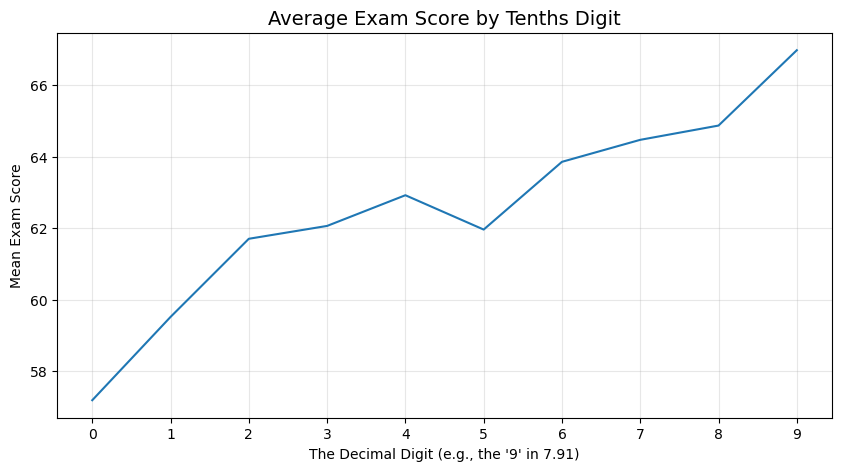

In [15]:
temp_d1 = ((train_df['study_hours'] * 10) % 10).astype(int)

digit_means = train_df.groupby(temp_d1)['exam_score'].mean()

plt.figure(figsize=(10, 5))
plt.plot(digit_means.index, digit_means.values)

plt.title("Average Exam Score by Tenths Digit", fontsize=14)
plt.xlabel("The Decimal Digit (e.g., the '9' in 7.91)")
plt.ylabel("Mean Exam Score")
plt.xticks(range(10))
plt.grid(True, alpha=0.3)
plt.show()

As can be seen in the graph, the tenths digit of study_hours has an impact on the average exam score. This is non-sensical, and its impact is as a result of the algorithm used by kaggle to make the synthetic dataset.

In [16]:
train_df["study_hours_digit"] = (train_df["study_hours"] * 10) % 10 

test_df["study_hours_digit"] = (test_df["study_hours"] * 10) % 10 

print("="*50)
print("Feature Added: study_hours_digit")
print("="*50)

Feature Added: study_hours_digit


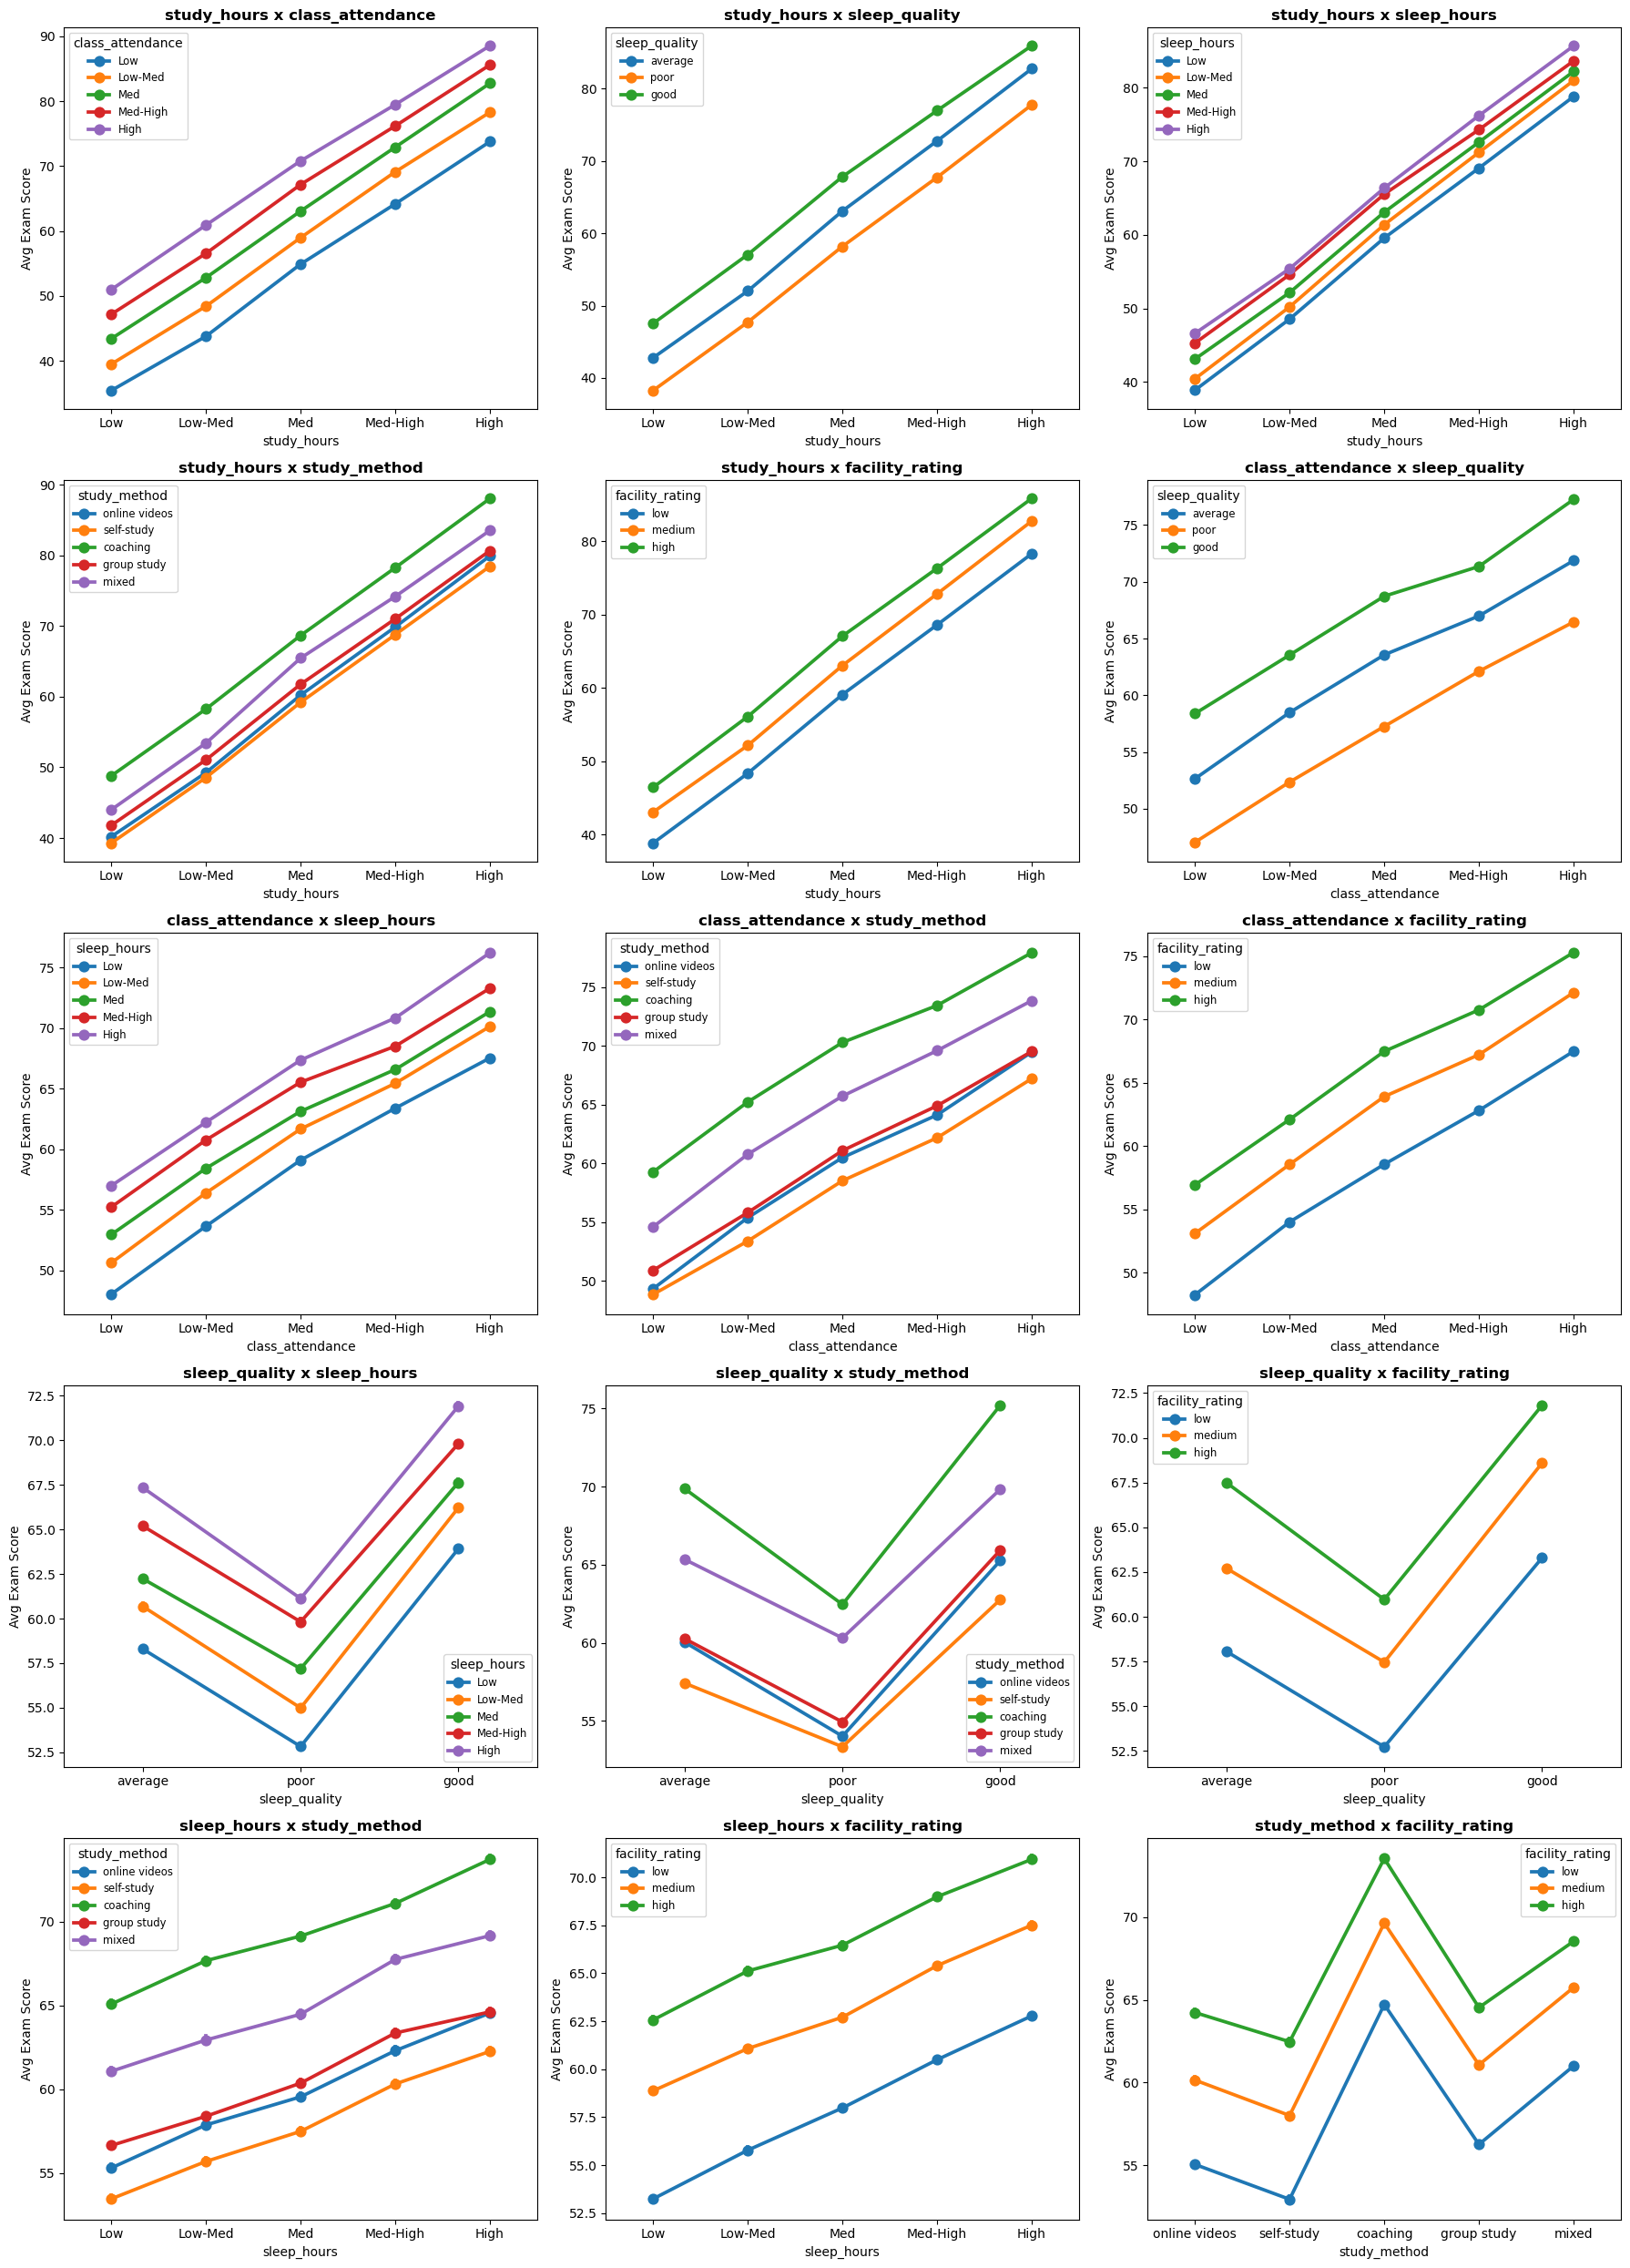

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
import math

top_features = ["study_hours", "class_attendance", "sleep_quality", 
                "sleep_hours", "study_method", "facility_rating"]

pairs = list(combinations(top_features, 2))
n_pairs = len(pairs)

cols = 3
rows = math.ceil(n_pairs / cols)

fig, axes = plt.subplots(rows, cols, figsize=(18, rows * 5))
axes = axes.flatten() 


def get_plot_data(df, col):
    if df[col].nunique() > 5:
        return pd.qcut(df[col], q=5, labels=['Low', 'Low-Med', 'Med', 'Med-High', 'High'], duplicates='drop')
    return df[col]

for i, (col_a, col_b) in enumerate(pairs):
    temp_x = get_plot_data(train_df, col_a)
    temp_hue = get_plot_data(train_df, col_b)
    
    sns.pointplot(
        ax=axes[i], 
        x=temp_x, 
        y=train_df['exam_score'], 
        hue=temp_hue)
    
    axes[i].set_title(f'{col_a} x {col_b}', fontsize=12, fontweight='bold')
    axes[i].set_xlabel(col_a)
    axes[i].set_ylabel('Avg Exam Score')
    axes[i].legend(title=col_b, loc='best', fontsize='small')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

We can see that the interaction effects have an impact on the following variables:
- study_hours x sleep_hours (numeric x numeric)
- study_hours x study_method (numeric x categorical)
- class_attendance x sleep_quality (numeric x categorical)
- class attendance x study_method (numeric x categorical)
- sleep_quality x study_method (categorical x categorical)
- sleep_hours x study_method (numeric x categorical)

In [18]:
train_df["study_hours-sleep_hours"] = train_df["study_hours"] * train_df["sleep_hours"]

test_df["study_hours-sleep_hours"] = test_df["study_hours"] * test_df["sleep_hours"]

print("="*50)
print(f"Feature added: study_hours-sleep_hours")  
print("="*50)

Feature added: study_hours-sleep_hours


In [19]:
numeric_cols = ["study_hours", "sleep_hours", "class_attendance"]

target_interactions = [
    ('study_hours', 'study_method'),
    ('class_attendance', 'sleep_quality'),
    ('class_attendance', 'study_method'),
    ('sleep_quality', 'study_method'),
    ('sleep_hours', 'study_method')
]

for (col1, col2) in target_interactions:
    col1_vals_train = train_df[col1].round(1).astype(str) if col1 in numeric_columns else train_df[col1].astype(str)
    col2_vals_train = train_df[col2].round(1).astype(str) if col2 in numeric_columns else train_df[col2].astype(str)

    new_col_train = col1_vals_train + '_' + col2_vals_train

    col1_vals_test = test_df[col1].round(1).astype(str) if col1 in numeric_columns else test_df[col1].astype(str)
    col2_vals_test = test_df[col2].round(1).astype(str) if col2 in numeric_columns else test_df[col2].astype(str)
    
    new_col_test = col1_vals_test + '_' + col2_vals_test
    
    combined = pd.concat([new_col_train, new_col_test], ignore_index=True)
    combined_encoded, _ = pd.factorize(combined)

    new_col_name = f"{col1}-{col2}"
    train_df[new_col_name] = combined_encoded[:len(train_df)]
    test_df[new_col_name] = combined_encoded[len(train_df):]

    print("="*50)
    print(f"Feature added: {new_col_name}")   
print("="*50)

Feature added: study_hours-study_method
Feature added: class_attendance-sleep_quality
Feature added: class_attendance-study_method
Feature added: sleep_quality-study_method
Feature added: sleep_hours-study_method


In [20]:
features = train_df.columns.drop("exam_score")
test_features = test_df.columns

features == test_features

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

In [21]:
train_df.columns

Index(['age', 'gender', 'course', 'study_hours', 'class_attendance',
       'internet_access', 'sleep_hours', 'sleep_quality', 'study_method',
       'facility_rating', 'exam_difficulty', 'exam_score', 'reg_feature',
       'reg_feature2', 'study_hours_poly_3', 'age_sq', 'class_attendance_sq',
       'study_hours_sq', 'sleep_hours_sq', 'study_hours_digit',
       'study_hours-sleep_hours', 'study_hours-study_method',
       'class_attendance-sleep_quality', 'class_attendance-study_method',
       'sleep_quality-study_method', 'sleep_hours-study_method'],
      dtype='object')

In [22]:
def create_oof_features(df, cols_to_encode, target_col, n_splits=5):
    new_df = df.copy()
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    aggs = ['mean', 'std', 'skew']
    
    global_stats = df[target_col].agg(aggs).to_dict()

    for col in cols_to_encode:
        for agg in aggs:
            new_df[f"{col}_{agg}"] = np.nan

    for train_idx, val_idx in kf.split(df):
        train_fold = df.iloc[train_idx]
        val_fold = df.iloc[val_idx]
        
        for col in cols_to_encode:
            group_stats = train_fold.groupby(col)[target_col].agg(aggs)
            
            for agg in aggs:
                new_df.loc[df.index[val_idx], f"{col}_{agg}"] = \
                    val_fold[col].map(group_stats[agg])
                
                fold_global_stat = train_fold[target_col].agg(agg)
                new_df.loc[df.index[val_idx], f"{col}_{agg}"] = \
                    new_df.loc[df.index[val_idx], f"{col}_{agg}"].fillna(fold_global_stat)
    return new_df

def apply_test_features(test_df, train_df, cols_to_encode, target_col):
    test_encoded = test_df.copy()
    aggs = ['mean', 'std', 'skew']
    
    for col in cols_to_encode:
        group_stats = train_df.groupby(col)[target_col].agg(aggs)
        
        for agg in aggs:
            test_encoded[f"{col}_{agg}"] = test_df[col].map(group_stats[agg])
            
            global_fallback = train_df[target_col].agg(agg)
            test_encoded[f"{col}_{agg}"] = test_encoded[f"{col}_{agg}"].fillna(global_fallback)
            
    return test_encoded

In [23]:
columns = ["study_hours",
    "class_attendance",
    "sleep_quality",
    "sleep_hours",
    "study_method",
    "facility_rating"]

target = "exam_score"

train_encoded = create_oof_features(train_df, columns, target)
test_encoded = apply_test_features(test_df, train_df, columns, target)

train_encoded = train_encoded.drop(train_df.columns, axis=1)
test_encoded = test_encoded.drop(test_df.columns, axis=1)

In [24]:
pd.concat([train_df, train_encoded], axis=1)
pd.concat([test_df, test_encoded], axis=1)

,age,gender,course,study_hours,class_attendance,internet_access,sleep_hours,sleep_quality,study_method,facility_rating,...,sleep_quality_skew,sleep_hours_mean,sleep_hours_std,sleep_hours_skew,study_method_mean,study_method_std,study_method_skew,facility_rating_mean,facility_rating_std,facility_rating_skew
id,,,,,,,,,,,,,,,,,,,,,
630000,24,other,ba,6.85,65.2,yes,5.2,poor,group study,high,...,0.041207,58.329330,18.630704,-0.083636,60.531838,18.219917,-0.004298,66.707126,18.525910,-0.104677
630001,18,male,diploma,6.61,45.0,no,9.3,poor,coaching,low,...,0.041207,66.661969,19.032898,-0.061753,69.266665,18.446089,-0.138123,57.954546,18.563344,0.002008
630002,24,female,b.tech,6.60,98.5,yes,6.2,good,group study,medium,...,-0.134124,62.759101,18.730044,-0.149043,60.531838,18.219917,-0.004298,63.028954,18.636271,-0.047315
630003,24,male,diploma,3.03,66.3,yes,5.7,average,mixed,medium,...,-0.038688,62.129919,18.352512,-0.120860,65.101735,18.218035,-0.182982,63.028954,18.636271,-0.047315
630004,20,female,b.tech,2.03,42.4,yes,9.2,average,coaching,low,...,-0.038688,66.455125,17.892458,-0.069699,69.266665,18.446089,-0.138123,57.954546,18.563344,0.002008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899995,21,other,b.com,2.55,82.3,yes,8.4,average,mixed,medium,...,-0.038688,64.325228,18.787289,-0.082888,65.101735,18.218035,-0.182982,63.028954,18.636271,-0.047315
899996,17,female,b.com,0.49,46.4,yes,8.8,good,mixed,low,...,-0.134124,64.579669,17.828284,-0.115427,65.101735,18.218035,-0.182982,57.954546,18.563344,0.002008
899997,22,male,bba,6.62,74.7,yes,5.5,good,coaching,high,...,-0.134124,57.570602,18.724969,0.059020,69.266665,18.446089,-0.138123,66.707126,18.525910,-0.104677


# Modelling

In [25]:
object_cols = train_df.select_dtypes(include=['object']).columns

for col in object_cols:
    train_df[col] = train_df[col].astype('category')

test_object_cols = test_df.select_dtypes(include=['object']).columns

for col in test_object_cols:
    test_df[col] = test_df[col].astype('category')

In [26]:
X = train_df.drop(target, axis=1)
y = train_df[target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBRegressor(
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=6,
    enable_categorical=True,
    early_stopping_rounds=50,
    tree_method="hist",
    device="cpu"
)


model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=False
)

pred = model.predict(X_val)


In [30]:
rmse = np.sqrt(mean_squared_error(y_val, pred))
r2 = r2_score(y_val, pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

RMSE: 8.7058
R2 Score: 0.7869


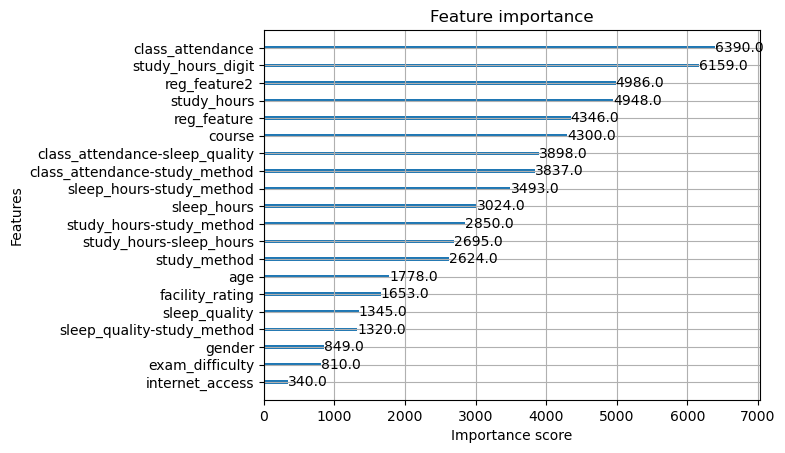

In [31]:
xgb.plot_importance(model)
plt.show()

In [32]:
test_ids = test_df.index
X_test = test_df
final_pred = model.predict(X_test)

In [33]:
submission = pd.DataFrame({
    'Id': test_ids,
    'exam_score': final_pred
})

# Save to CSV without the index
submission.to_csv('submission.csv', index=False)

print("Submission file saved as 'submission.csv'!")

Submission file saved as 'submission.csv'!


# Review

Due to time constraints, a number of improvements to this submission can be made that have been omitted. For example:
- Investigation into the study_hours_digit feature. Do the digits of other features also have an impact?
- Experimentation with ensemble modelling
- More advanced hyperparamter tuning using a grid search
- Comparison of tree-based models and neural network approaches

